# Graph Introduction

這篇筆記是圖神經網路的 pytorch 實戰，首先，我們要先保證我們的裝置上有 GPU 提供訓練，我們可以透過在終端輸入 nvidia-smi 來查看可供使用的 GPU, 以及目前 GPU 上的程式進程 (Process)

1. Google Colab 提供免費的 T4 (16GB)
2. Kaggle 提供免費的 2 張 T4 (16GB) 和一張 P100 (16GB)


In [ ]:
!nvidia-smi

Thu Jul 13 19:14:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## DGL

dgl 是一個目前比較通用的圖神經網路庫，他支援的後端引擎有 pytorch 和 tensorflow，但是目前維護主要以 pytorch 為主，官方文檔對於 pytorch 解釋也比較完善

我們必須先查看 cuda 對應的版本號安裝對應的 dgl 庫，具體安裝方法詳見 [https://www.dgl.ai/pages/start.html](https://www.dgl.ai/pages/start.html)

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -q -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -q -f https://data.dgl.ai/wheels-test/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 51.2 MB/s eta 0

## 導入 DGL 庫

當我們使用 GPU 資源加速圖網路計算時，我們必須訂後端計算框架，可選用的框架包含 pytorch, mxnet, tensorflow，我們可以透過 `os.environ["DGLBACKEND"]` 去設置後端資源

In [ ]:
# Set DGL backend
import os
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import torch
import networkx as nx

### So, what is a graph?

圖表示了一系列實體 (node) 之間的關係 (edge)，每張圖中的點與邊都有自己的屬性

- **node:** degree of the node
- **edge:** weight
- **graph:** number of nodes and edges, longest path

我們透過把這些屬性向量化得到圖得特徵

### Edge Type

實體之間的關係不一定是雙向的，舉例來說，若我們把 twitter 用戶看做實體，實體之間的追蹤關係定義為邊，則大多數情況下，A 追蹤 B 不會有 B 追蹤 A，因此我們用一條有向邊 (directed) 從 A 指向 B，代表著 A 對 B 產生了追蹤的行為

- `A:` 為邊的起點，通常稱為 `src` (source)
- `B:` 為邊的終點，通常稱為 `dst` (destination)

實體之間的關係也可以是雙向的，舉例來說，我們把 twitter 用戶看做實體，實體之間的好友關係定義為邊，則 B 接受 A 的交友邀請，則 A 和 B 是朋友，B 和 A 也是朋友，因此我們用一條無向邊 (undirected) 連接 A 和 B

**Note:** 連接 $A, B$ 的無向邊等於兩條有向邊，分別連接 $A\to B$ 和 $B\to A$

![](https://hackmd.io/_uploads/SJZrrcQHh.png)


### Graph Type

對於圖內的實體節點，可以是同構 (homogeneous) 或異構 (heterogeneous) 的

- 同構: 所有節點代表同一類型的實體，邊也代表同一種關係
  - 例如在 twitter 的範例中，點代表用戶實體，邊代表追蹤關係
- 異構: 節點可以代表不同類型的實體，邊也可以代表不同種關係
  - 在表示市場關係的圖中，點可以代表消費者或商家兩種實體，邊可以代表想購買、已經購買、是不是顧客、正在銷售等等
  - 二分圖是一種特殊的異構圖，其邊連接兩種不行類型的節點

![](https://hackmd.io/_uploads/H1uy3i7H2.png)

Note: 除了利用節點與邊的類型分為同構與異構圖，也可以根據圖的變化分為靜態與動態



### Graph to Vector

到目前為止，我們對於圖有了差不多的了解之後，我們來思考如何把圖做向量化，在向量部分，我們來討論怎麼向量化點、邊、全局信息和連接性

在以下的討論中，我們只談談同構圖的向量方法，異構圖只是在同構圖的基礎上分成不同的點集合和邊集合而已

#### Node Vector

對於神經網路，大部分的資料都是表格狀的 (tabular)，一個很直觀的想法就是用一個矩陣來表示點的屬性

- 矩陣大小: (number of nodes, nodes embeddings dimension)
- 矩陣 $i$-row: 第 $i$ 個點的屬性

#### Edge Vector

同樣地，我們可以用一樣的方法表示邊

- 矩陣大小: (number of edges, edges embeddings dimension)
- 矩陣 $i$-row: 第 $i$ 條邊的屬性

#### Global-context Vector

同樣地，我們可以用一樣的方法表示圖

- 矩陣大小: (number of graphs, graphs embeddings dimension)
- 矩陣 $i$-row: 第 $i$ 張圖的屬性

#### Connectivities Vector

對於連接性，數學家通常使用 adjacency matrix 來表示點集合的連接性，但是這個方法有一些缺點

1. 當點的數量很多，邊卻很少時，我們的 adjacency matrix 會非常的 sparse
2. adjacency matrix 不具有 permutation invariant。當我把矩陣的點順序打亂後，不同的 adjacency matrix 可以表示同一種連接方式

一個比較有效率的做法是使用 adjacency list，我們先把點做編號，我們用一對 tuple 儲存一條邊 `(src_id, dst_id)`，這樣做法的空間複雜度為 $\mathcal{O}(edge)$ 相比於之前 adjacency matrix $\mathcal{O}(node^2)$ 較不佔內存

#### DGL build graph

接下來我們用 DGL 去建立一張圖

- `dgl` api
  - `add_edges:` 將原圖加上新的邊
  - `add_nodes:` 將原圖加上新的點
  - `to_bidirected(graph):` 將有向圖轉成無向圖
  - `to_networkx(graph):` 將 dgl 物件轉成 networkx 物件
  - `to_block(graph):` 將 dgl 物件轉成 block 格式 (我們會在第 3 章介紹)
  - `add_self_loop(graph):` 將點 $v$ 加上 $(v, v)$ 的邊
- `dgl.graph(data, idtype)` api
  - `graph:` $(u, v)$ 圖上的邊
  - `idtype:` 儲存圖結構的資料型態


In [ ]:
def build_karate_club_graph():
    # add 34 nodes into the graph; nodes are labeled from 0~33
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    # for speed up, we transfer graph to int32
    g = dgl.graph((src, dst), idtype=torch.int32, num_nodes=34)
    # make Directed Acyclic Graph to Undirected Graph
    g = dgl.to_bidirected(g)

    return g

In [ ]:
g = build_karate_club_graph()
print(g)
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})
We have 34 nodes.
We have 156 edges.


In [ ]:
# print the id of the nodes and edges
print(g.nodes())
print(g.edges())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
       dtype=torch.int32)
(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
        31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33], dtype=torch.int32), tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
         3,  7, 13, 17,

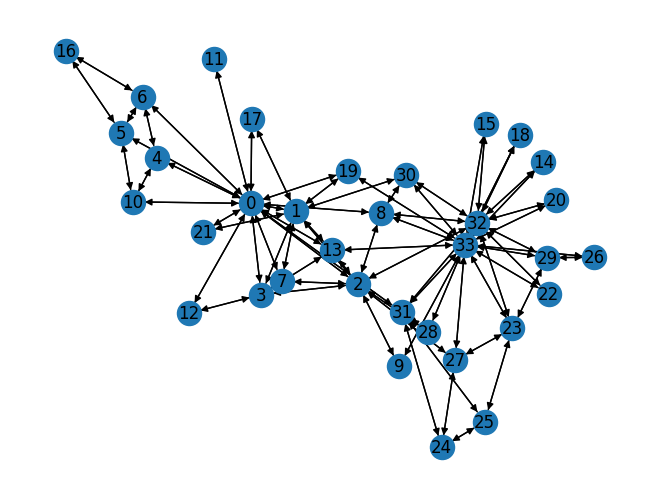

In [ ]:
nx.draw(g.to_networkx(), with_labels=True)

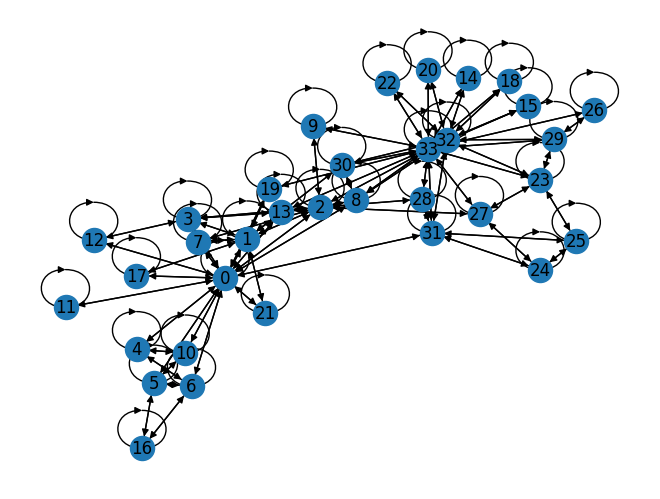

In [ ]:
self_loop_graph = dgl.add_self_loop(g)
nx.draw(self_loop_graph.to_networkx(), with_labels=True)

#### Add attributes

DGL 提供兩個接口用來儲存點與邊的屬性

- `g.ndata[key]=value:` `key` 為屬性名，`value` 為張量，大小為 `(number of nodes, node embeddings dimension...)`
- `g.edata[key]=value:` `key` 為屬性名，`value` 為張量，大小為 `(number of edges, edge embeddings dimension...)`

Note:

1. 特徵必須是數值向量
2. 張量第一維度必須與點或邊數量相等
3. 同屬性的 embeddings dimension 必須一致

In [ ]:
g.ndata['x'] = torch.eye(g.number_of_nodes()) # shape: (number of nodes, node embeddings dimension)
g.edata["x"] = torch.ones(g.number_of_edges(), dtype=torch.int32) # shape: (number of edges, edge embeddings dimension)
g.edata["w"] = torch.ones(g.number_of_edges(), dtype=torch.int32)
g.ndata['y'] = torch.randn(g.num_nodes(), 5)

In [ ]:
idx = 0
name = "y"
print(f"node id {idx} | feature {name} embeddings: {g.ndata[name][idx]}")
idx = torch.tensor([0,1])
name = "w"
print(f"edge id ({idx[0]}, {idx[1]}) | feature {name} embeddings: {g.edata[name][idx]}")

node id 0 | feature y embeddings: tensor([-0.9715,  1.5234,  0.9408, -0.4992, -0.9195])
edge id (0, 1) | feature w embeddings: tensor([1, 1], dtype=torch.int32)


#### Build Heterograph

同樣地方法，我們也可以用來建構異構圖

建立方法為給定一個字典，

- `key: (src_type, edge_type, dst_type)`
- `value: (src, dst)`

In [ ]:
import dgl
import torch
# 3 種類型的節點跟 3 種類型的邊
graph_data = {
   ('drug', 'interacts', 'drug'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (torch.tensor([1]), torch.tensor([2]))
}
g = dgl.heterograph(graph_data)
print(g.ntypes)
print(g.etypes)
print(g.canonical_etypes)
print(g.metagraph)
print(g.num_nodes("drug"))
print(g.nodes("drug"))

['disease', 'drug', 'gene']
['interacts', 'interacts', 'treats']
[('drug', 'interacts', 'drug'), ('drug', 'interacts', 'gene'), ('drug', 'treats', 'disease')]
<bound method DGLGraph.metagraph of Graph(num_nodes={'disease': 3, 'drug': 3, 'gene': 4},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'interacts', 'gene'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts'), ('drug', 'disease', 'treats')])>
3
tensor([0, 1, 2])


對於特定實體型態的資料我們可以用以下方式獲得

g.nodes[`node_type`].data[`feat_name`] 和 g.edges[`edge_type`].data[`feat_name`]

In [ ]:
# assign value
g.nodes['drug'].data['hv'] = torch.ones(3, 1)
print(g.nodes['drug'].data['hv'])

g.edges['treats'].data['he'] = torch.zeros(1, 1)
print(g.edges['treats'].data['he'])

g.edges[('drug', 'interacts', 'gene')].data['he'] = torch.zeros(2, 1)
print(g.edges['treats'].data['he'])

tensor([[1.],
        [1.],
        [1.]])
tensor([[0.]])
tensor([[0.]])


創建子圖

我們可以透過想要保留的邊類型去創建異構圖的子圖，且該圖會保留 `src` 和 `dst` 信息

In [ ]:
# 保留关系 ('drug', 'interacts', 'drug') 和 ('drug', 'treats', 'disease') 。
# 'drug' 和 'disease' 类型的节点也会被保留
eg = dgl.edge_type_subgraph(g, [('drug', 'interacts', 'drug'),('drug', 'treats', 'disease')])
print(eg)
print(eg.nodes['drug'].data['hv'])

Graph(num_nodes={'disease': 3, 'drug': 3},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'disease', 'treats')])
tensor([[1.],
        [1.],
        [1.]])


異構圖轉化為同構圖

對於不同節點或邊有相同特徵，我們可以合併為同一類，但是請注意

1. 相同特徵的資料 embeddings 維度要一致

在下面的例子中，對於特徵 `he`，`interacts` 類型的邊 embeddings dimension 是 `1`，然而 `treats` 類型的邊 embeddings dimension 是 `2`，所以基於特徵 `he` 的合併操作會報錯

In [ ]:
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('drug', 'treats', 'disease'): (torch.tensor([1]), torch.tensor([2]))})
g.nodes['drug'].data['hv'] = torch.zeros(3, 1)
g.nodes['disease'].data['hv'] = torch.ones(3, 1)
g.edges['interacts'].data['he'] = torch.zeros(2, 1)
g.edges['treats'].data['he'] = torch.zeros(1, 2)
# 默认情况下不进行特征合并
hg = dgl.to_homogeneous(g)
# 拷贝边的特征
# 对于要拷贝的特征，DGL假定不同类型的节点或边的需要合并的特征具有相同的大小和数据类型
# hg = dgl.to_homogeneous(g, edata=['he'])
# 拷贝节点特征
hg = dgl.to_homogeneous(g, ndata=['hv'])
hg.ndata['hv']

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]])

In [ ]:
# 异构图中节点类型的顺序
print(g.ntypes)
# 原始节点类型
print(hg.ndata[dgl.NTYPE])
# 合併節儉類型
print(hg.ntypes)
# 原始的特定类型节点ID
print(hg.ndata[dgl.NID])
# 异构图中边类型的顺序
print(g.etypes)
# 原始边类型
print(hg.edata[dgl.ETYPE])
# 原始的特定类型边ID
print(hg.edata[dgl.EID])

['disease', 'drug']
tensor([0, 0, 0, 1, 1, 1])
['_N']
tensor([0, 1, 2, 0, 1, 2])
['interacts', 'treats']
tensor([0, 0, 1])
tensor([0, 1, 0])


#### Third-party build graph

除了使用 DGL API 之外，我們也可以用第三方套件建立圖，DGL 為我們第三方套件提供了接口

1. `dgl.from_scipy:`
2. `dgl.from_network:`

In [ ]:
import scipy.sparse as sp
import networkx as nx

spmat = sp.rand(100, 100, density=0.05) # 5%非零项
dgl.from_scipy(spmat)                   # 来自SciPy

nx_g = nx.path_graph(5) # 一条链路0-1-2-3-4
dgl.from_networkx(nx_g) # 来自NetworkX

nxg = nx.DiGraph([(2, 1), (1, 2), (2, 3), (0, 0)])
dgl.from_networkx(nxg)

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

#### Graph on GPU

我們可以透過將圖結構複製 `(to)` 到 GPU 上加速訓練

Note: 任何圖的操作必須保證操作元屬於同一裝置 (都在 GPU 上或者都在 CPU 上)

In [ ]:
devices_id = 0
if torch.cuda.is_available():
  print("GPU is available!!")
  g = g.to(f"cuda:{devices_id}")
else:
  g = g.to("cpu")
print(g.device)

GPU is available!!
cuda:0


#### Save Graph

DGL 提供了一種接口利用二進制去保存圖的信息結構

- `dgl.data.utils.save_graphs(filename, g_lists, label):`
   - `filename:` 檔案名稱
   - `g_lists:` 要儲存的圖
   - `label:` 用來儲存 graph-level 信息
- `dgl.data.utils.load_graphs(filename):`
   - `filename:` 檔案名稱
  

In [ ]:
g1 = dgl.graph(([0, 1, 2], [1, 2, 3]))
g2 = dgl.graph(([0, 2], [2, 3]))
g2.edata["e"] = torch.ones(2, 4)
graph_labels = {"glabel": torch.tensor([0, 1])}
dgl.save_graphs("./data.bin", [g1, g2], graph_labels)

glist, label_dict = dgl.load_graphs("./data.bin") # glist will be [g1, g2]
print(glist)
glist, label_dict = dgl.load_graphs("./data.bin", [0]) # glist will be [g1]
print(glist)

[Graph(num_nodes=4, num_edges=3,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=4, num_edges=2,
      ndata_schemes={}
      edata_schemes={'e': Scheme(shape=(4,), dtype=torch.float32)})]
[Graph(num_nodes=4, num_edges=3,
      ndata_schemes={}
      edata_schemes={})]


### Laplacian Matrix on Graph

dgl 提供了一些方便的 API 幫助我們找出圖上的鄰接矩陣和拉普拉斯矩陣

- `dgl.laplacian_lambda_max(g):` 找出圖上的 Laplacian 對應的最大特徵值
- `dgl.khop_adj(g, k):` 找出圖上鄰接矩陣的 $k$ 次方

更多有關 Laplacian graph 相關知識詳見我的另外一篇筆記 [Spectral Graph Convolution]

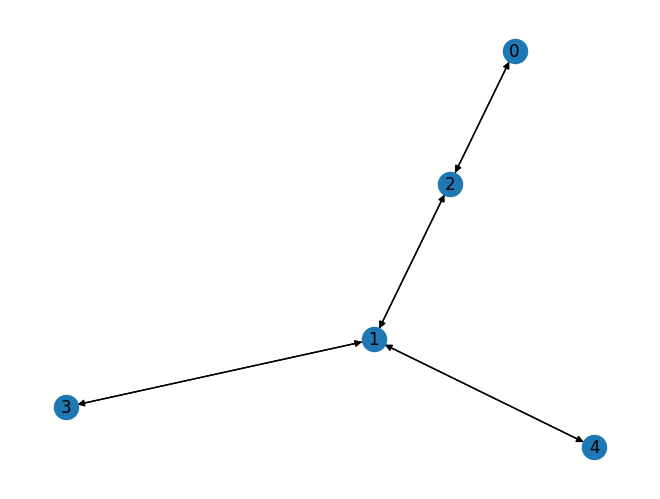

In [ ]:
g = dgl.graph(((0,2,1,1), (2,1,3,4)))
g = dgl.to_bidirected(g)
nx.draw(g.to_networkx(), with_labels=True)

In [ ]:
dgl.laplacian_lambda_max(g), dgl.khop_adj(g, 1)

([1.9999999999999991],
 tensor([[0., 0., 1., 0., 0.],
         [0., 0., 1., 1., 1.],
         [1., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]))

### Data as Graph

回想起我們對於圖的定義，只要實體之間存在關係，我們就可以使用圖來表示數據

#### Image as Graph



In [ ]:
import numpy as np
import networkx as nx

# Read the image and convert it to grayscale
image = np.array([
    [0,1,0,1,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [1,0,0,0,1],
    [0,1,1,1,0]
]) * 255
# Create an empty graph
graph = nx.Graph()

# Get the dimensions of the image
height, width = image.shape

# Iterate over each pixel in the image
for i in range(height):
    for j in range(width):
        # Add the current pixel as a node in the graph
        graph.add_node((i, j))

        # Check the 8 neighboring pixels
        neighbors = [(i-1, j-1), (i-1, j), (i-1, j+1),
                     (i, j-1),             (i, j+1),
                     (i+1, j-1), (i+1, j), (i+1, j+1)]

        # Add edges between the current pixel and its neighbors
        for neighbor in neighbors:
            if 0 <= neighbor[0] < height and 0 <= neighbor[1] < width:
                graph.add_edge((i, j), neighbor)

# Generate the adjacency list
adjacency_list = nx.generate_adjlist(graph)

# Print the adjacency list
for line in adjacency_list:
    print(line)


(0, 0) (0, 1) (1, 0) (1, 1)
(0, 1) (0, 2) (1, 0) (1, 1) (1, 2)
(1, 0) (1, 1) (2, 0) (2, 1)
(1, 1) (0, 2) (1, 2) (2, 0) (2, 1) (2, 2)
(0, 2) (0, 3) (1, 2) (1, 3)
(1, 2) (0, 3) (1, 3) (2, 1) (2, 2) (2, 3)
(0, 3) (0, 4) (1, 3) (1, 4)
(1, 3) (0, 4) (1, 4) (2, 2) (2, 3) (2, 4)
(0, 4) (1, 4)
(1, 4) (2, 3) (2, 4)
(2, 0) (2, 1) (3, 0) (3, 1)
(2, 1) (2, 2) (3, 0) (3, 1) (3, 2)
(2, 2) (2, 3) (3, 1) (3, 2) (3, 3)
(2, 3) (2, 4) (3, 2) (3, 3) (3, 4)
(2, 4) (3, 3) (3, 4)
(3, 0) (3, 1) (4, 0) (4, 1)
(3, 1) (3, 2) (4, 0) (4, 1) (4, 2)
(3, 2) (3, 3) (4, 1) (4, 2) (4, 3)
(3, 3) (3, 4) (4, 2) (4, 3) (4, 4)
(3, 4) (4, 3) (4, 4)
(4, 0) (4, 1)
(4, 1) (4, 2)
(4, 2) (4, 3)
(4, 3) (4, 4)
(4, 4)


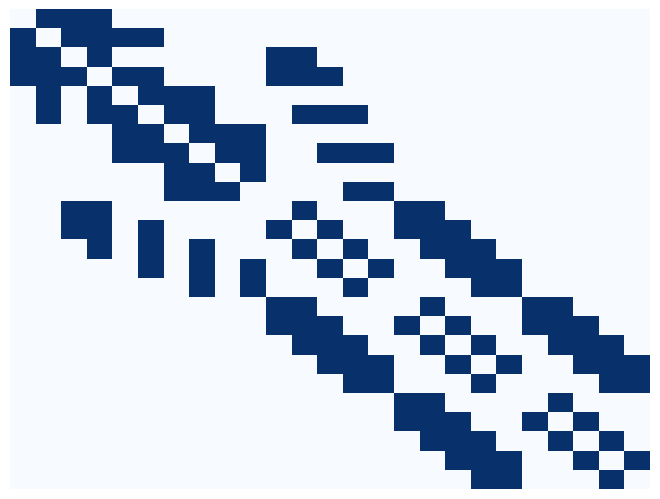

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
array = nx.adjacency_matrix(graph).todense()
plt.imshow(array, cmap='Blues', aspect='auto')
plt.xticks(range(25), range(25))
plt.yticks(range(25), range(25))
# plt.axis('off')
plt.gca().set_axis_off()
plt.gca().set_facecolor('black')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('graph_without_background.png', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

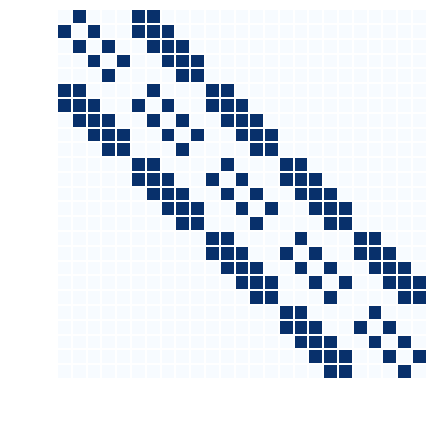

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'tile' is already defined as a 25x25 numpy array
array = nx.adjacency_matrix(graph, nodelist=[(j,i) for j in range(5) for i in range(5)]).todense()
# Create a new array with a black gap between each pixe

# Set the color palette to only display blue color
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the image with black gaps and grid lines using seaborn
ax = sns.heatmap(array, cmap=cmap, cbar=False, linewidths=0.1, linecolor='white', square=True)

# Set the ticks and labels
ax.set_xticks(np.arange(25) + 0.5)
ax.set_yticks(np.arange(25) + 0.5)
ax.set_xticklabels([(j,i) for j in range(5) for i in range(5)], color="white")
ax.set_yticklabels([(j,i) for j in range(5) for i in range(5)], color="white")
plt.tick_params(left=False, bottom=False)
plt.savefig('graph_without_background.png', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


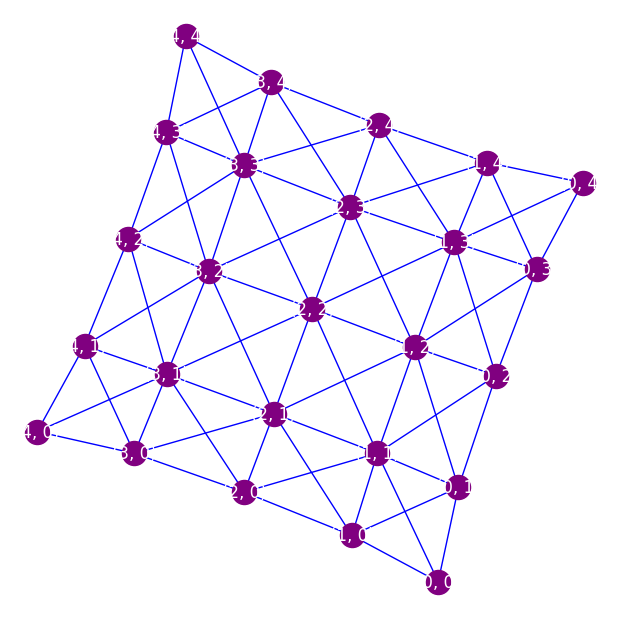

In [ ]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Read the image and convert it to grayscale
image = np.array([
    [0,1,0,1,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [1,0,0,0,1],
    [0,1,1,1,0]
]) * 255

# Create an empty graph
graph = nx.Graph()

# Get the dimensions of the image
height, width = image.shape

# Iterate over each pixel in the image
for i in range(height):
    for j in range(width):
        # Add the current pixel as a node in the graph
        graph.add_node((i, j))

        # Check the 8 neighboring pixels
        neighbors = [(i-1, j-1), (i-1, j), (i-1, j+1),
                     (i, j-1),             (i, j+1),
                     (i+1, j-1), (i+1, j), (i+1, j+1)]

        # Add edges between the current pixel and its neighbors
        for neighbor in neighbors:
            if 0 <= neighbor[0] < height and 0 <= neighbor[1] < width:
                graph.add_edge((i, j), neighbor)

# Draw the graph
pos = nx.spring_layout(graph, k=0.15)  # Adjust the "k" parameter for better spacing
labels = {(i, j): f'({i}, {j})' for i, j in graph.nodes}

plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(graph, pos, node_color='purple')
nx.draw_networkx_edges(graph, pos, edge_color='blue')
nx.draw_networkx_labels(graph, pos, labels, font_color='white')  # Set label color to black and add a white background

# Remove the axis and background
plt.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save the graph without background
plt.savefig('graph_without_background.png', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


#### Text as graph

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]


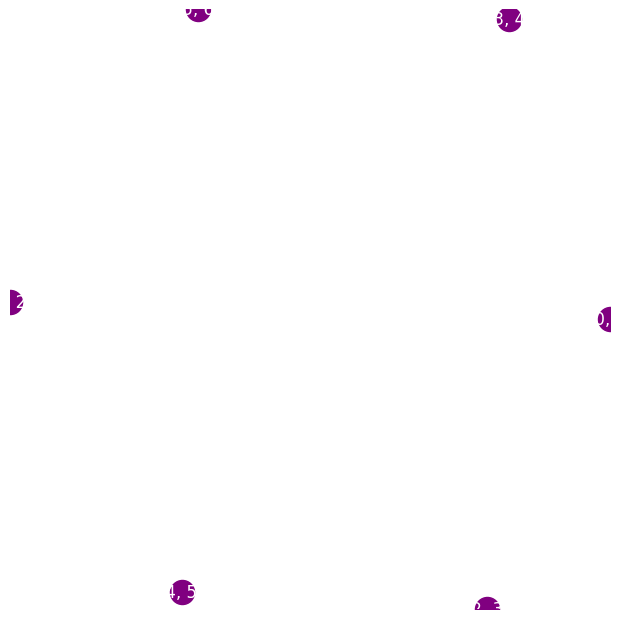

In [ ]:
text = "DongDong is the greatest of all time"
graph = nx.Graph()
for i in range(6):
    graph.add_node((i,i+1))

pos = nx.spring_layout(graph, k=0.15)  # Adjust the "k" parameter for better spacing
print(graph.nodes)
labels = {(i, j): f'({i}, {j})' for i, j in graph.nodes}

plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(graph, pos, node_color='purple')
nx.draw_networkx_edges(graph, pos, edge_color='blue')
nx.draw_networkx_labels(graph, pos, labels, font_color='white')  # Set label color to black and add a white background

# Remove the axis and background
plt.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save the graph without background
plt.savefig('graph_without_background.png', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Solving problem with graph

本章節會簡介我們可以用圖來解決什麼樣的問題，圖主要分為三個最主要的部件，圖、點和邊，對於這三個主要成員，我們都可以根據我們的問題建立相對應的模型

#### Graph-level Task

在 Graph-level 的任務中，我們想要**比較不同圖之間的差異**，對於整張圖做出判讀。比較簡單的例子例如化學分子的毒性判斷，在化學分子的任務中，我們的圖結構可以有以下表示

- **Graph:** 一個化學分子
- **Node:** 原子 (H, O, He, ...)
- **Edge:** 氫鍵

我們可以根據原子以及邊的連接方式，判斷這個化學分子是有毒或是無毒的

1. 圖分類（Graph Classification）：這個任務的目標是將整個圖分類到不同的類別或標籤中。例如，在化學分子結構中，可以通過分類化合物的功能類型來進行圖分類。
2. 圖生成（Graph Generation）：這個任務要求生成新的圖結構，以擴展現有的圖數據。通常，這涉及到生成具有類似拓撲結構和屬性的新圖。這對於分子設計、社交網絡生成等場景具有重要意義。
3. 圖屬性預測（Graph Property Prediction）：這個任務旨在預測整個圖的全局屬性或特徵。例如，在社交網絡中，可以通過預測整個社區的影響力或情感傾向來進行圖屬性預測。
4. 圖聚類（Graph Clustering）：這個任務的目標是將圖中的節點或子圖進行分組或聚類，以發現圖中的隱含結構和相似性。這對於社交網絡分組、推薦系統的用戶分群等具有重要意義。

#### Node-level Task

在 Node-level 的任務中，我們想要**比較不同實體之間的差異**，對於圖內的每個實體做分析。這裡舉個最經典的例子 karate club dataset，它描述了一個由 Zachary Karate Club 所組成的社交網絡。這個數據集主要由兩個部分組成：34個節點（代表俱樂部成員）和 78 條邊（代表俱樂部成員之間的關係）。在研究期間，這個俱樂部發生了以 Mr. Hi" (Instructor) 和 John H (Administrator) 為主的分裂，我們的任務是判斷俱樂部成員會比較支持 Mr. Hi 還是 John H

- **Graph:** 俱樂部
- **Node:** 成員
- **Edge:** 成員之間的關係

對於點上的預測，在 CV 和 NLP 都有類似的概念，Node-level 任務相當於 CV 中的影像分割，當我們把每一個 pixel 看成是圖上的一個點，我們必須根據他周遭的空間特徵去預測該點屬於哪一個實體類型。在 NLP 中，類似的概念像是 POS tagging，在給定一串 token，我們要根據前後文信息預測當前 token 的詞性

Node-level 任務當然不只這些，廣泛來說，有以下幾種

1. 節點分類（Node Classification）：這個任務的目標是將圖中的每個節點分類到不同的類別或標籤中。例如，在社交網絡中，可以通過分類用戶的興趣或職業來進行節點分類。
2. 節點表示學習（Node Embedding）：這個任務旨在學習每個節點的低維度嵌入表示，將其映射到連續向量空間中。這些節點表示可以用於節點相似性計算、聚類、可視化等任務。常用的方法包括將節點嵌入為固定維度的向量，如使用GraphSAGE、GAT等。
3. 節點回歸（Node Regression）：這個任務的目標是預測圖中每個節點的數值型屬性。例如，在推薦系統中，可以通過預測用戶對產品的評分來進行節點回歸。
4. 節點生成（Node Generation）：這個任務要求生成新的節點，以擴展現有的圖結構。通常，這涉及到生成具有類似特徵的新節點，以便與現有節點相互連接。這對於圖生成、數據擴充等場景具有重要意義。

#### Edge-level Task

在 Edge-level 的任務中，我們想要**比較不同實體之間關係得差異**，對於圖內的每個關係都做出判讀。這項任務可以非常廣泛用在不同領域之中，舉個例子來說，假設我們想要知道一張影像中每個實體的關係，我們可以先用 Transformer 得到實體的實例分割，在根據實例分割建立圖網路來判讀每條邊的關係

- **Graph:** 影像
- **Node:** 實例
- **Edge:** 實例之間的關係

在這種任務中，我們通常輸入一個完全圖，然後根據實力的屬性判斷每條邊之間的關係

1. 邊分類（Edge Classification）：這個任務的目標是對圖中的每條邊進行分類，將它們劃分為不同的類別或標籤。例如，在社交網絡中，可以通過分類邊的關係類型（如友誼、家庭關係等）來預測人際關係。
2. 邊預測（Link Prediction）：這個任務旨在預測圖中可能存在但尚未觀察到的邊。通過分析圖中已有的邊和節點特徵，預測潛在的連接關係。這對於社交網絡推薦、產品推薦或合作關係預測等場景非常有用。
3. 邊重構（Graph Reconstruction）：這個任務要求根據圖的部分信息重建缺失的邊。這在網絡修復、數據恢復和圖形恢復等場景中具有重要應用。
4. 邊排序（Edge Ranking）：這個任務的目標是對圖中的邊進行排序，以反映它們的重要性或相似性。這對於社交網絡中的好友排序、搜索引擎的頁面排序等具有重要意義。